<a href="https://colab.research.google.com/github/devkwesi12/python-machinelearning-project/blob/main/ENFS_GARBAGE_CLASSIFICATION_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Garbage Classification Model
The goal of this assignment is to develop a classification model that
uses PyTorch to solve the problem from assignment 01 (i.e., garbage classification) using both the image and textual information.

# 1. Import Libraries

In [ ]:

# 1. IMPORT LIBRARIES


import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.nn.utils.rnn import pad_sequence
from collections import Counter

from sklearn.metrics import classification_report, confusion_matrix


# 2. Set Device (GPU if available)

In [ ]:

# 2. DEVICE CONFIGURATION


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Define Dataset Paths

In [ ]:

# 3. DATA PATHS


TRAIN_PATH = "/content/drive/MyDrive/cpvr_train"
VAL_PATH   = "/content/drive/MyDrive/cpvr_val"
TEST_PATH  = "/content/drive/MyDrive/cpvr_test"


# 4. Image Preprocessing

In [ ]:

# 4. IMAGE TRANSFORMS


train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),   # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )
])


# . Load ImageFolder

In [ ]:

# 5. LOAD BASE DATASETS


train_base = ImageFolder(TRAIN_PATH)
val_base   = ImageFolder(VAL_PATH)
test_base  = ImageFolder(TEST_PATH)

class_names = train_base.classes
num_classes = len(class_names)

print("Classes:", class_names)


Classes: ['Black', 'Blue', 'Green', 'TTR']


# text Processing Part


In [ ]:
# ===============================
# 6. TEXT PROCESSING UTILITIES
# ===============================

def build_vocab(imagefolder):
    """
    Build vocabulary from training filenames.
    """
    counter = Counter()

    for path, _ in imagefolder.imgs:
        filename = os.path.basename(path)
        filename = os.path.splitext(filename)[0]

        # Remove class prefix
        words = filename.split('_')[1:]
        counter.update(words)

    # Special tokens
    vocab = {"<PAD>":0, "<UNK>":1}

    for word in counter:
        vocab[word] = len(vocab)

    return vocab


def encode_text(words, vocab):
  return torch.tensor(
    [vocab.get(w, vocab["<UNK>"]) for w in words],
    dtype=torch.long
)



In [ ]:
#Vocabulary built from training data
vocab = build_vocab(train_base)
print("Vocabulary size:", len(vocab))


Vocabulary size: 375


# CUSTOM MULTIMODAL DATASET

# Dataset Class

In [ ]:

# 8. CUSTOM MULTIMODAL DATASET


class GarbageDataset(Dataset):
    def __init__(self, imagefolder, vocab, transform=None):
        self.imagefolder = imagefolder
        self.vocab = vocab
        self.transform = transform

    def __len__(self):
        return len(self.imagefolder)

    def __getitem__(self, idx):
        # Get image and label
        image, label = self.imagefolder[idx]
        img_path = self.imagefolder.imgs[idx][0]

        # Extract text from filename
        filename = os.path.basename(img_path)
        filename = os.path.splitext(filename)[0]

        words = filename.split('_')[1:]   # Remove class prefix
        text_tensor = encode_text(words, self.vocab)

        # Apply transform
        if self.transform:
            image = self.transform(image)

        return image, text_tensor, label


## Collate Function

In [ ]:
# ===============================
# 9. COLLATE FUNCTION
# ===============================

def collate_fn(batch):
    images, texts, labels = zip(*batch)

    images = torch.stack(images)
    labels = torch.tensor(labels)

    # Pad variable-length text sequences
    texts = pad_sequence(texts, batch_first=True, padding_value=0)

    return images, texts, labels


## Data Loaders

In [ ]:
train_dataset = GarbageDataset(train_base, vocab, train_transform)
val_dataset   = GarbageDataset(val_base, vocab, test_transform)
test_dataset  = GarbageDataset(test_base, vocab, test_transform)

trainloader = DataLoader(train_dataset, batch_size=16,
                         shuffle=True, collate_fn=collate_fn)

valloader = DataLoader(val_dataset, batch_size=16,
                       shuffle=False, collate_fn=collate_fn)

testloader = DataLoader(test_dataset, batch_size=16,
                        shuffle=False, collate_fn=collate_fn)

# Model Architecture

## Text Encoder (LSTM)

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)

        return hidden[-1]   # Final hidden state


## Multimodal model

In [ ]:
class GarbageModel(nn.Module):
    def __init__(self, num_classes, vocab_size):
        super().__init__()

        # ----- IMAGE BRANCH -----
        self.image_model = models.resnet18(weights="IMAGENET1K_V1")

        # Freeze early layers
        for param in self.image_model.parameters():
            param.requires_grad = False

        # Unfreeze last block
        for param in self.image_model.layer4.parameters():
            param.requires_grad = True

        # Remove original classifier
        self.image_model.fc = nn.Identity()

        # ----- TEXT BRANCH -----
        self.text_model = TextEncoder(vocab_size)

        # ----- FUSION CLASSIFIER -----
        self.classifier = nn.Sequential(
            nn.Linear(512 + 128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, text):
        img_feat = self.image_model(image)
        text_feat = self.text_model(text)

        combined = torch.cat((img_feat, text_feat), dim=1)
        return self.classifier(combined)


In [ ]:
model = GarbageModel(num_classes, len(vocab)).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 110MB/s]


In [ ]:
epochs = 5
best_val_loss = float("inf")

train_losses = []
val_losses = []

for epoch in range(epochs):

    # ---- TRAINING ----
    model.train()
    train_loss = 0

    for images, texts, labels in trainloader:
        images = images.to(device)
        texts = texts.to(device).long()
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(trainloader)
    train_losses.append(train_loss)

    # ---- VALIDATION ----
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, texts, labels in valloader:
            images = images.to(device)
            texts = texts.to(device).long()
            labels = labels.to(device)

            outputs = model(images, texts)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(valloader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model")


Epoch 1
Train Loss: 1.0151
Val Loss: 1.0531
Saved best model
Epoch 2
Train Loss: 0.5470
Val Loss: 0.9826
Saved best model
Epoch 3
Train Loss: 0.3835
Val Loss: 0.9688
Saved best model
Epoch 4
Train Loss: 0.2560
Val Loss: 0.9705
Epoch 5
Train Loss: 0.1921
Val Loss: 0.9822


## Learning Curve

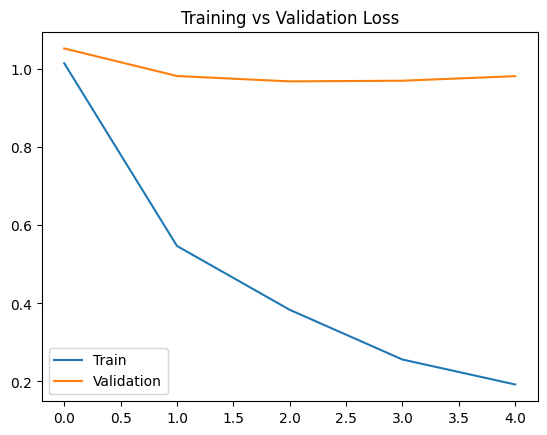

In [ ]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [ ]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, texts, labels in testloader:
        images = images.to(device)
        texts = texts.to(device)

        outputs = model(images, texts)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())


## Metrics

In [ ]:
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print("Test Accuracy:", accuracy)

print(classification_report(all_labels, all_preds, target_names=class_names))


Test Accuracy: 0.6333333333333333
              precision    recall  f1-score   support

       Black       0.77      0.33      0.47        30
        Blue       0.58      1.00      0.73        30
       Green       0.93      0.47      0.62        30
         TTR       0.55      0.73      0.63        30

    accuracy                           0.63       120
   macro avg       0.71      0.63      0.61       120
weighted avg       0.71      0.63      0.61       120



## Confusion Matrix


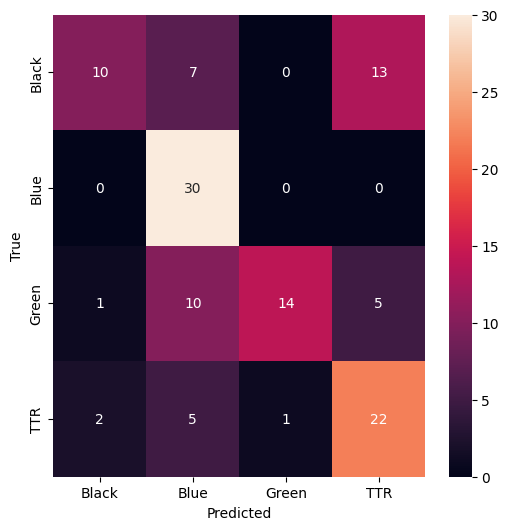

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


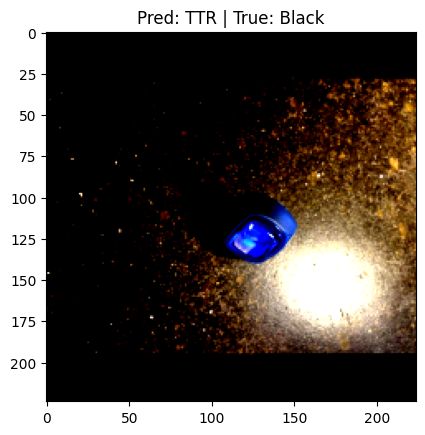

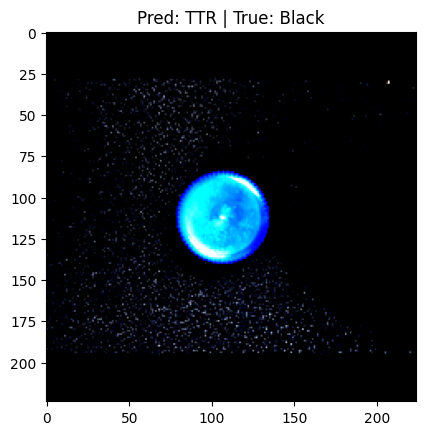

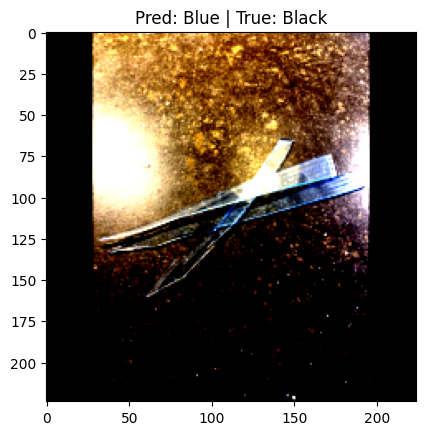

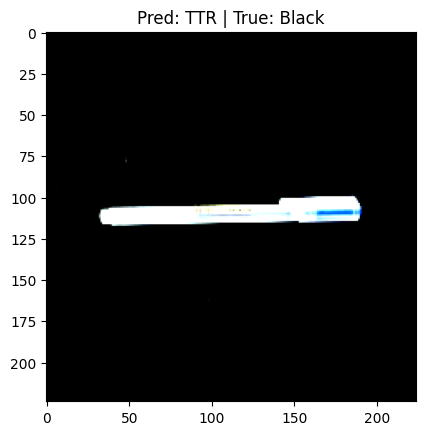

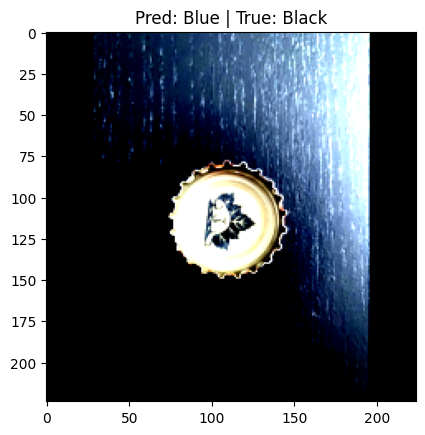

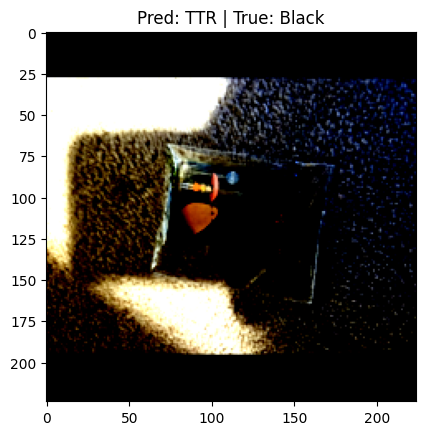

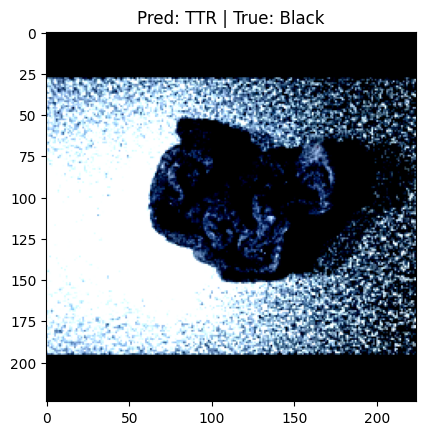

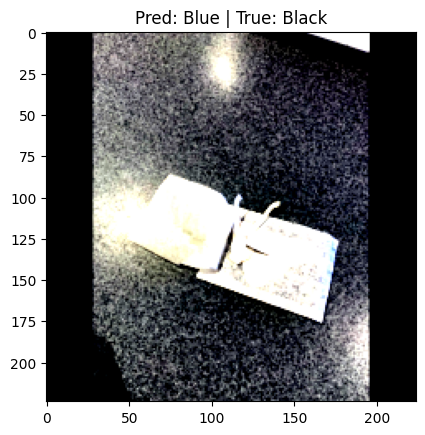

In [ ]:
model.eval()
shown = 0

with torch.no_grad():
    for images, texts, labels in testloader:
        images = images.to(device)
        texts = texts.to(device)

        outputs = model(images, texts)
        preds = torch.argmax(outputs, dim=1)

        for i in range(len(preds)):
            if preds[i] != labels[i] and shown < 8:
                img = images[i].cpu().permute(1,2,0)
                plt.imshow(img)
                plt.title(f"Pred: {class_names[preds[i]]} | True: {class_names[labels[i]]}")
                plt.show()
                shown += 1


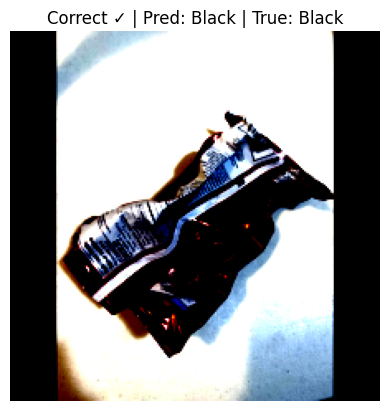

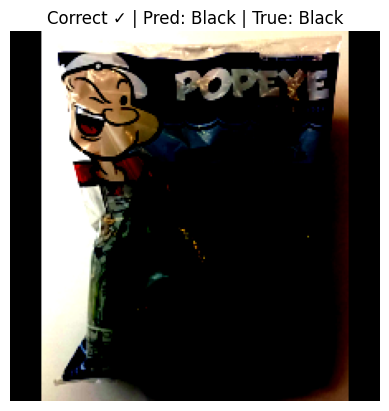

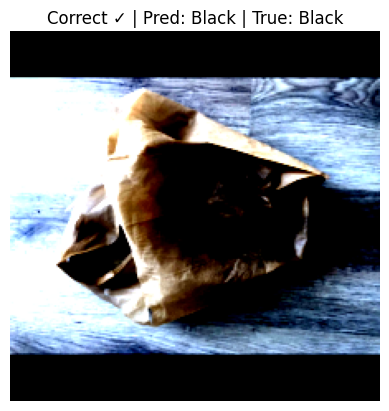

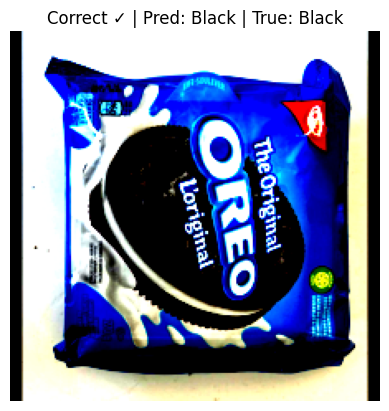

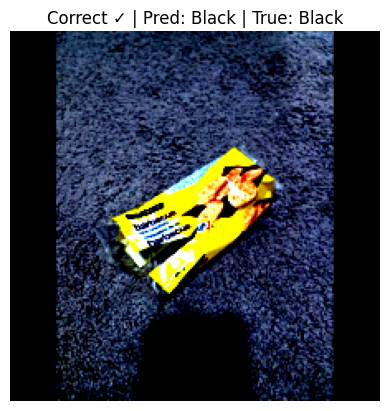

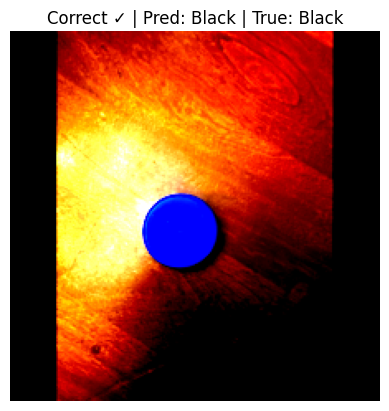

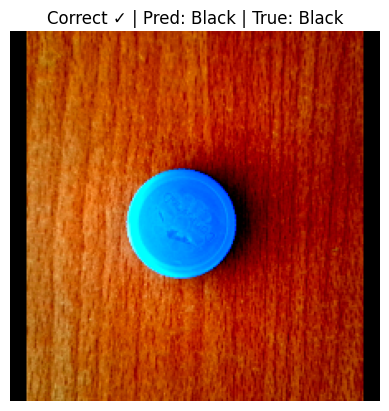

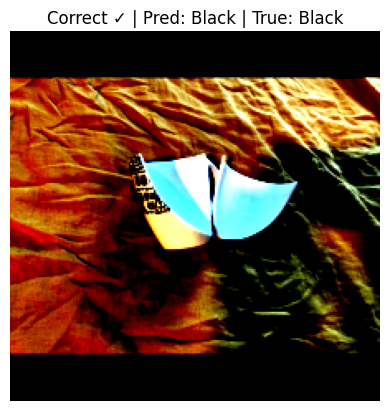

In [ ]:
import matplotlib.pyplot as plt

model.eval()
shown = 0

with torch.no_grad():
    for images, texts, labels in testloader:
        images = images.to(device)
        texts = texts.to(device).long()
        labels = labels.to(device)

        outputs = model(images, texts)
        preds = torch.argmax(outputs, dim=1)

        for i in range(len(preds)):
            if preds[i] == labels[i] and shown < 8:   # ← changed here
                img = images[i].cpu().permute(1, 2, 0)

                plt.imshow(img)
                plt.title(
                    f"Correct ✓ | Pred: {class_names[preds[i]]} | True: {class_names[labels[i]]}"
                )
                plt.axis("off")
                plt.show()

                shown += 1
